In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image
import glob
import os
import shutil

2023-07-09 10:56:05.454299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# img = Image.open('./../carvana/train/151c7f2d4183_11.jpg')

img = Image.open('./../carvana/train/151c7f2d4183_11.jpg')

# get the image format (JPEG, PNG, etc.)
print('Format:', img.format)

# get the image size (width, height)
print('Size:', img.size)

# get the image mode (RGB, CMYK, etc.)
print('Mode:', img.mode)

Format: JPEG
Size: (1918, 1280)
Mode: RGB


In [3]:
mask = Image.open('./../carvana/train_masks/1aba91a601c6_04_mask.gif')

# get the image format (JPEG, PNG, etc.)
print('Format:', mask.format)

# get the image size (width, height)
print('Size:', mask.size)

# get the image mode (RGB, CMYK, etc.)
print('Mode:', mask.mode)

Format: GIF
Size: (1918, 1280)
Mode: P


In [4]:
import os

path = os.path.join('./../carvana/train/')

os.listdir(path)[:5]

['917f262f1608_02.jpg',
 '28109f18d9d4_09.jpg',
 '4bea0766c14c_04.jpg',
 '03a857ce842d_09.jpg',
 '1b25ea8ba94d_03.jpg']

In [5]:
# set the directories for the image files
root_dir = './../carvana/'
file_path = root_dir + 'train/*.*'
file_mask_path = root_dir + 'train_masks/*.*'

image_file = sorted(glob.glob(file_path))
mask_file = sorted(glob.glob(file_mask_path))

img_dir = image_file
seg_dir = mask_file

# create a dataset from the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((img_dir, seg_dir))

In [6]:
# define e a function to load and preprocess the images and segmentation images
def load_image(file_path, seg_path):
    # load the image file
    img = tf.io.read_file(file_path)
    
    # decode the image file
    img = tf.image.decode_jpeg(img, channels=3)
    
    # preprocess the image (e.g. resize, normalize, etc.)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.0
    
    # load the segmentation image file
    seg = tf.io.read_file(seg_path)
    
    # decode the segmentation image file
    seg = tf.squeeze(tf.io.decode_gif(seg), axis=0)
    
    # preprocess the segmentation image (e.g. resize, normalize, etc.)
    seg = tf.image.resize(seg, [256, 256])
    seg = tf.cast(seg, tf.float32) / 255.0
    return img, seg

In [7]:
# map the load_image function to the dataset
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# define the batch size and shuffle the dataset
batch_size = 64

# define the size of the validation set as a fraction of the total dataset size
val_size = 0.2

# calculate the number of validation examples
val_size = int(len(img_dir) * val_size)

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=1000)

# split the dataset into training and validation datasets
val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

In [8]:
train_batches = (
    train_dataset
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_batches = val_dataset.batch(batch_size)

In [9]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

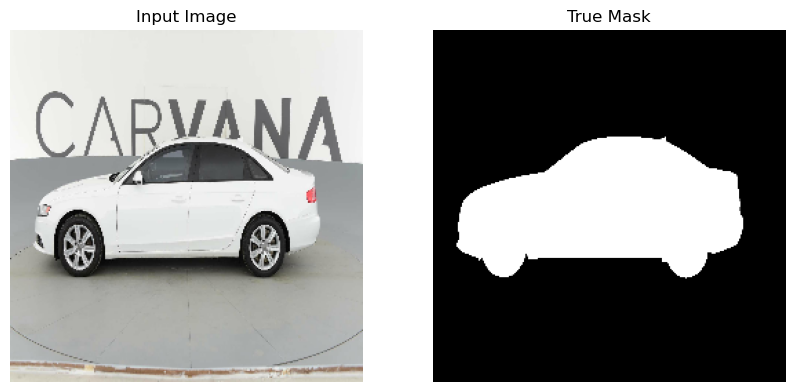

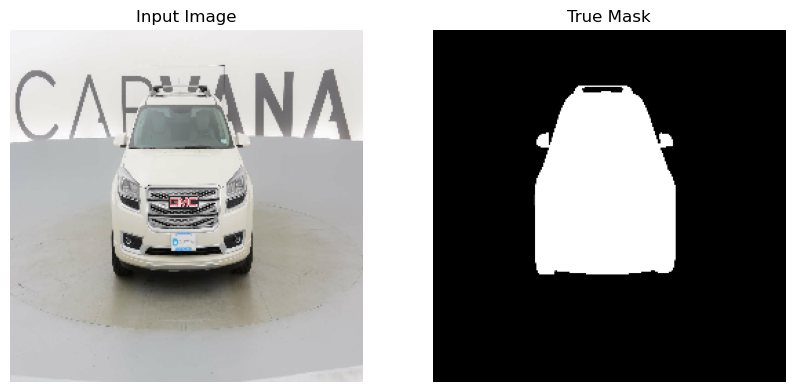

In [10]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [11]:
# define the encoder block
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = tf.random_normal_initializer(0.02)
    # add downsampling layer
    g = layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = layers.BatchNormalization()(g, training=True)
    # leaky relu activation
    g = layers.LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02,)
    # add upsampling layer
    g = layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same',
                              kernel_initializer=init)(layer_in)
    # add batch normalization
    g = layers.BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = layers.Dropout(0.3)(g, training=True)
    # merge with skip connection
    g = layers.Concatenate()([g, skip_in])
    g = layers.Activation('relu')(g)
    return g

# define the U-Net model
def UNet(image_shape=(256, 256, 3)):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02)
    # image input
    in_image = keras.Input(shape=image_shape)
    
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = layers.Activation('relu')(b)
    
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    
    # output 
    g = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = layers.Activation('sigmoid')(g)
    model = keras.Model(in_image, out_image)
    return model

In [12]:
image_shape = (256, 256, 3)
model = UNet(image_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 8, 8, 512)   8389120     ['activation_2[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 512)   2048        ['conv2d_transpose_2[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 8, 8, 512)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 concatenate_2 (Concatenate)    (None, 8, 8, 1024)   0           ['dropout_2[0][0]',              
          

![UNet-Structure](UNet_structure.png)

In [13]:
def dice_score(y_true, y_pred, smooth=1):
    # flatten the true and predicted masks
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # calculate the intersection and union of the masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # calculate the Dice score
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def iou_score(y_true, y_pred, smooth=1):
    # flatten the true and predicted masks
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # calculate the intersection and union of the masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # calculate the IoU score
    iou = (intersection + smooth) / (union + smooth)

    return iou

In [14]:
# compile the model with the evaluation metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_score, iou_score])

In [ ]:
# train the model and monitor the evaluation metrics
history = model.fit(train_batches, epochs=100, validation_data=val_batches)

Epoch 1/100


2023-07-09 10:56:18.422149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.3512 - dice_score: 0.4554 - iou_score: 0.2277

2023-07-09 10:56:39.686851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 26s 174ms/step - loss: 0.3512 - dice_score: 0.4554 - iou_score: 0.2277 - val_loss: 0.1859 - val_dice_score: 0.7017 - val_iou_score: 0.3508
Epoch 2/100
64/64 [==============================] - 10s 140ms/step - loss: 0.1224 - dice_score: 0.8130 - iou_score: 0.4065 - val_loss: 0.0643 - val_dice_score: 0.9067 - val_iou_score: 0.4534
Epoch 3/100
64/64 [==============================] - 11s 147ms/step - loss: 0.0529 - dice_score: 0.9232 - iou_score: 0.4616 - val_loss: 0.0469 - val_dice_score: 0.9350 - val_iou_score: 0.4675
Epoch 4/100
64/64 [==============================] - 11s 135ms/step - loss: 0.0373 - dice_score: 0.9454 - iou_score: 0.4727 - val_loss: 0.0368 - val_dice_score: 0.9447 - val_iou_score: 0.4724
Epoch 5/100
64/64 [==============================] - 10s 134ms/step - loss: 0.0298 - dice_score: 0.9564 - iou_score: 0.4782 - val_loss: 0.0280 - val_dice_score: 0.9586 - val_iou_score: 0.4793
Epoch 6/100
64/64 [==============================] -

In [ ]:
def show_predictions(dataset=val_batches):
    if dataset:
        for image, mask in dataset.take(5):
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])

In [ ]:
show_predictions()

In [ ]:
model.save("carvana-unet.h5")